In [1]:
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from ngrams import Ngram

from TypicalityEnginev0_2 import Typicality

In [2]:
# 1. 
df = pd.read_csv("../NMvW_data/v0.csv.gz", 
                 dtype=dict(Provenance="string", RelatedWorks="string")).iloc[:5000]

# TODO: save & load DF s.t. these lines are not necessary here                
df["ObjectID"] = df.ObjectID.astype("int")
df = df.set_index("ObjectID")
df = df.replace(np.nan, "")

# 2.
# def get_text(row):
#     return row[["Title", "Description"]]    
    
# texts = (t for i, row in df.iterrows() for t in get_text(row))

texts = list(df["Title"]) + list(df["Description"])

# ng = Ngram(ns=3, documents=texts, precompute_freqs=True)

In [3]:
texts = list(df.Title) + list(df.Description)

In [4]:
typ = Typicality(texts, take_abs=False)

(2, 3)-grams: Padding documents...: 100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 829159.63it/s]


(2, 3)-grams: Term Document Matrix constructed...
(2, 3)-grams: Term frequencies precomputed...
(2, 3)-grams: Init done


(0, 1)-grams: Padding documents...: 100%|████████████████████████████████| 10000/10000 [00:00<00:00, 1147144.38it/s]


(0, 1)-grams: Term Document Matrix constructed...
(0, 1)-grams: Term frequencies precomputed...
(0, 1)-grams: Init done


100%|█████████████████████████████████████████████████████████████████████| 11239/11239 [00:00<00:00, 263609.93it/s]


In [5]:
results = df[["Title", "Description"]].progress_apply(axis='columns', 
         func=lambda r: typ.process_object(r))
obj_typs = results.apply(lambda t: t[1])
w_typs = results.apply(lambda t: dict(t[0]))

100%|█████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1018.76it/s]


---
## Inspection

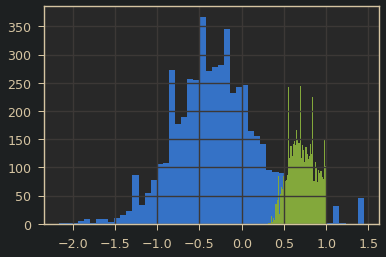

In [7]:
_ = plt.hist(obj_typs, bins=50) #, histtype="step", color="r")

_ = plt.hist(1/(abs(obj_typs)+1), bins=50) #, histtype="step", color="r")

8.526512829121201e-18

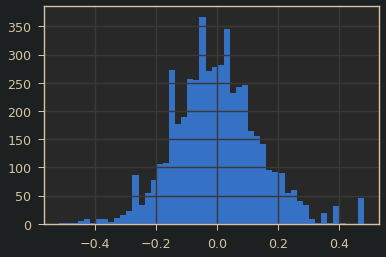

In [8]:
o = (obj_typs-obj_typs.mean())/(obj_typs.max() - obj_typs.min())
_ = plt.hist(o, bins=50) #, histtype="step", color="r")
o.mean()

In [ ]:
sorted(zip(map(lambda r: r[1]["Title"], 
               df[["Title", "Description"]].iterrows()),
          obj_typs), 
       key=lambda tup: tup[1], reverse=True)[:100]

In [ ]:
lens = [len(row["Title"]+row["Description"]) 
        for i, row in df[["Title", "Description"]].iterrows()]
lens = np.asarray(lens)
# os = obj_typs/(np.asarray(lens)+1)
os = obj_typs

sns.jointplot(x=np.log(lens), y=os)
from scipy.stats import pearsonr, spearmanr
pearsonr(np.log(lens+1), os), spearmanr(np.log(lens+1), os)

In [ ]:
ws, lens, ts = list(zip(*[(w, len(w), t) for d in w_typs for w, t in d.items()]))
ts = np.asarray(ts)

sns.jointplot(x=lens, y=ts)
pearsonr(lens, ts), spearmanr(lens, ts)

In [ ]:
sorted(set(zip(ws, ts)), key=lambda t: t[1], reverse=True)

In [ ]:
typ.uni_model.prob("drie"),1/np.exp(typ.uni_H)

In [ ]:
typ.uni_H, typ.uni_model.prob("van", log=True)

In [ ]:
sorted({(w, t) for d in w_typs for w, t in d.items()}, key=lambda t: t[1], reverse=True)

In [ ]:
plt.hist(1/(np.asarray(ts)+1), bins=50)

In [ ]:
plt.hist(1/(np.asarray(obj_typs)+1), bins=50)

In [ ]:
import numpy.random as rand
l = 2
sorted(rand.randint(5, size=10))[-l:]

In [ ]:
typ_E.model.vocab((3))

---
# Develop Engine

In [9]:
class Engine:
    def __init__(self, id_, name, dataset, params):
        self.id = id_ # str
        self.name = name # str
        self.dataset = dataset # datasets.Dataset
        self.params = params # list of EngineParam
        
    def prep_engine_params(self, param_dict):
        return {p.id: param_dict.get(p.id, p.default_value) for p in self.params}
#         return {p.id: p.get() for p, v in self.params}

    
    def description(self):
        with open(f"src/engines/{self.id}.html") as handle:
            html = handle.read()
            
        with open("src/engines/descriptions.css") as handle:
            css = handle.read()
        
        html = html.replace("<style></style>",
                    "<style>"+css+"</style>")
        return html
    
    def __hash__(self):
        return hash((self.__class__, self.id, self.name))

    def to_dict(self):
        return {
            "id": self.id,
            "name": self.name,
            "min_score": self.min_score,
            "params": [p.to_dict() for p in self.params]
        }

In [10]:
e = Engine(1, "abc", [], {})

e.to_dict()

AttributeError: 'Engine' object has no attribute 'min_score'

In [ ]:
class TypicalityEngine(Engine):
    def __init__(self, typicality, **engine_params):
        super().__init__(**engine_params)
        self.min_score = 0. # np.random.random()*100

        texts = self.dataset.data.apply(lambda r: 
                                        r["Title"] + r["Description"], axis="columns")
        self.typicality = typicality  # Typicality(texts)
        
        
        
#         a(o) = |H(P) - [- 1/|o|*log(P(o))]|
#         a(o) > 0
        
#         a(o) < inf 
#         -> practically: a(o) < a(o') w. o' minimises P(o') 
#         => could use to change a: O -> [0, inf) into a': O -> [0, 1]


In [ ]:
 params = dict(zip(["id_", "name", "dataset", "params"],
                   [1, "abc", df, {}]))

t = TypicalityEngine(typ, **params)